## 2. This module determines the effect of PBDOT.

Calculate PBDOT based on the timing.
This will find the proper values of PBDOT that can be used for simulation


!! This code uses galactic longitude and lattitude. I checked the conversion with YMW16 (J1713) for DM distance measur, and PBDOT_gal with J2222. They are consistent when I used galactic definition of coordinate. 

In [96]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, math, numpy as N, matplotlib.pyplot as P
from libstempo.libstempo import *
import libstempo
import libstempo.plot as LP, libstempo.toasim as LT
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import libstempo as T
import pandas as pd
import subprocess
from astropy.constants import G
from astropy.constants import c
from astropy.stats import LombScargle
from astropy import constants as const

class params:
    
    def __init__(self):
        pass
    
    def call_parameters(name):
        call=(open(name).read())
        call=re.sub(r'\t', ' ', call)
        call=call.split('\n')

        param_array=np.zeros(0)
        for i in range(0,len(call)):
            each_line=np.array(call[i].split(' ')) 
            each_line=each_line[each_line!='']
            if each_line[0]=='CLK':
                break
            else:
                pass
            param_array=np.append(param_array,each_line)
        return param_array
    
    def param_finder(array,param):
        param_idx=np.where(array==param)
        param_name=array[param_idx]

        param_val=array[param_idx[0]+1]
        #param_err=array[param_idx[0]+3]
        if param=='RAJ' or param=='DECJ': 
            if param=='RAJ':
                head='h'
                head_sub='d'
                param_idx_sub=np.where(array=='DECJ')
                param_name_sub=array[param_idx_sub]
                param_val_sub=array[param_idx_sub[0]+1]
                #param_err_sub=array[param_idx_sub[0]+3]
            if param=='DECJ':
                head='d'
                head_sub='h'
                param_idx_sub=np.where(array=='RAJ')
                param_name_sub=array[param_idx_sub]
                param_val_sub=array[param_idx_sub[0]+1]
                #param_err_sub=array[param_idx_sub[0]+]

            coord=''
            err_part=''
            locator=0

            for i in param_val[0]:
                if i==':': 
                    if locator==0:
                        i=head

                    locator=locator+1
                if locator<=1:
                    coord=coord+i
                if locator>1:
                    err_part=err_part+i

            upper=float(err_part[1:])+float(param_err[0])
            lower=float(err_part[1:])-float(param_err[0])

            coord_upper=coord+'m'+str(upper)
            coord_lower=coord+'m'+str(lower)

            coord_sub=''
            err_part_sub=''
            locator_sub=0
            
            for i in param_val_sub[0]:
                if i==':': 
                    if locator_sub==0:
                        i=head_sub
                    locator_sub=locator_sub+1
                if locator_sub<=1:
                    coord_sub=coord_sub+i
                if locator_sub>1:
                    err_part_sub=err_part_sub+i


            sub_part=float(err_part_sub[1:])
            coord_sub=coord_sub+'m'+str(sub_part)
             

            if param=='RAJ':
                coord_lw= SkyCoord(coord_upper, coord_sub, frame='icrs')
                coord_up= SkyCoord(coord_lower, coord_sub, frame='icrs')  
                mean=(coord_lw.galactic.frame.l.deg+coord_up.galactic.frame.l.deg)/2
                #err=(mean-coord_lw.galactic.frame.l.deg)

            if param=='DECJ':
                coord_lw= SkyCoord(coord_sub, coord_upper, frame='icrs')
                coord_up= SkyCoord(coord_sub, coord_lower, frame='icrs')            
                mean=(coord_lw.galactic.frame.b.deg+coord_up.galactic.frame.b.deg)/2
                #err=(mean-coord_lw.galactic.frame.b.deg)

            param_val=mean
            #param_err=err
                
        else:
            param_val=float(param_val[0])
            #param_err=float(param_err[0])
      
        return param_name,param_val


class PK(params):
    def __init__(self):
        pass
    
    def pbdot(mass_m2, mass_m1, d, param):
        array_al=params.call_parameters('Original_Model.par')

        e=params.param_finder(array_al,'ECC')[1]
        pmra=params.param_finder(array_al,'PMRA')[1]*4.8481368110954e-9
        pmdec=params.param_finder(array_al,'PMDEC')[1]*4.8481368110954e-9
        pb=params.param_finder(array_al,'PB')[1]
        
        #l=params.param_finder(array_al,'RAJ')[0]
        #b=params.param_finder(array_al,'DECJ')[0]
        
        mu2=pmra**2+pmdec**2

        
        def pbd_gw(mass_m2, mass_m1, e, pb):
            t0=4.925490947*1e-6
            pb=pb*u.day.to('second')
            m=mass_m2+mass_m1
            return -192*np.pi/5*(pb/2/np.pi)**(-5/3)*(1+73/24*e**2+37/96*e**4)*(1-e**2)**(-7/2)*t0**(5/3)*mass_m2*mass_m1*m**(-1/3)


        def pbd_shk(mu2,d,pb): 
            
            dist=d*u.kpc.to('m')#np.random.normal(d,dd,iterations)*3.09e+16 # to m
            c=const.c.value/3.17098e-8 # to m/yt
            pb=pb*u.day.to('yr') # to yr
            
            return mu2*pb*dist/c
 

        def pbd_gal(ra, decj, pb, d):
            
            MYR = 1e+6*365.25*86400*u.s
            DAY = 86400 * u.s
            KPC = (1.0*u.kpc).value
            R0    = 8.20  * u.kpc 
            z_sun = 0.014 * u.kpc 
            Phi = GalaxyPotential("pot/PJM17_best.Tpot")
            coord.galactocentric_frame_defaults.set('v4.0')
            scSgrA = SkyCoord(ra=266.416817*u.deg, dec=-29.007825*u.deg, distance=R0, frame=ICRS, equinox='J2000.0')
            scSun  = SkyCoord(ra=0*u.deg, dec=0*u.deg, distance=0*u.kpc, frame=coord.ICRS, equinox='J2000.0')
            gc_frame = coord.Galactocentric(galcen_coord=scSgrA,galcen_distance=R0,z_sun=z_sun,roll=-0.0057822*u.deg) 

            #example coordinate

            # Original RAJ,DECJ were determined by generating random array.

            PSR  = "NGC1851E"
            Pb   = pb * DAY
            #d    = d * u.kpc

            # coordinate transformation
            gal_Pbdot=np.zeros(0)
            for i in d:
                scPsr  = SkyCoord('{0:s} {1:s}'.format(ra, decj), unit=(u.hourangle, u.deg), distance=i*u.kpc, frame=ICRS, equinox='J2000')
                print(scPsr)
                    # Express the coordinates of the sun and the pulsar with respect to the SgrA 

                gcSun  = scSun.transform_to(gc_frame)
                gcPsr  = scPsr.transform_to(gc_frame)

                    #Express the coordinate for each vector

                Xsun = np.array([gcSun.x/u.kpc, gcSun.y/u.kpc, gcSun.z/u.kpc])
                Rsun = np.sqrt(Xsun[0]**2 + Xsun[1]**2)
                Xpsr = np.array([gcPsr.x/u.kpc, gcPsr.y/u.kpc, gcPsr.z/u.kpc])
                Rpsr = np.sqrt(Xpsr[0]**2 + Xpsr[1]**2)


                    # find the acceleration difference


                fRzSun = Phi.ForceRz(Rsun,Xsun[2])
                accSun = np.array([-fRzSun[0], 0, fRzSun[1]]) * u.kpc/MYR**2

                fRzPsr = Phi.ForceRz(Rpsr,Xpsr[2])
                accPsr = np.array([fRzPsr[0]*Xpsr[0]/Rpsr, fRzPsr[0]*Xpsr[1]/Rpsr, fRzPsr[1]]) * u.kpc/MYR**2


                XX = Xpsr - Xsun
                K0 = XX/np.linalg.norm(XX)
                acc_diff = accPsr - accSun


                    # find PbDOT by Galactic Potential
                PdotP = np.dot(K0, acc_diff)/c # Pdot/P
                gal_Pbdot=np.append(gal_Pbdot,(PdotP * Pb).si)
                
            return gal_Pbdot
        
        #gal_dist=pbd_gal(l,b, pb, d, iterations)
        shk_dist=pbd_shk(mu2,d,pb)
        pbd_gw_factor=pbd_gw(mass_m2, mass_m1, e,pb)
        
        total=shk_dist+pbd_gw_factor
        return total
 
def ephemeris_gen(i,Invest,d):

    mass_m2=1.25
    mass_m1=1.25

    array_al=params.call_parameters('Original_Model.par')


    pbdot=PK.pbdot(mass_m2, mass_m1, d, params)

    sini=str(np.sin(i*np.pi/180))
    m2=mass_m2
    
    stig=np.sqrt((1-np.cos(i*np.pi/180))/(1+np.cos(i*np.pi/180)))
    h3=stig**3*4.925490947e-6*mass_m2 
    h4=h3*stig

       
    SPR_another_param='STIG            '
    value=str(stig)
    

    if Invest=='pbdot':
        PBD='PBDOT            '+str(pbdot)+' 1        0\n'
        M2='H3            '+str(h3)+'         0\n'
        SINI=SPR_another_param+value+'       0\n'
    if Invest=='spr':
        PBD='PBDOT            '+str(pbdot)+'         0\n'
        M2='H3            '+str(h3)+'   1      0\n'
        SINI=SPR_another_param+value+'   1       0\n'
    print(m2)
    
    data=open('Original_Model.par')
    texts=data.read()

    perfect_model_params=texts+M2+SINI+PBD
    perfect_model=open('Perfect_Model.par', "w")
    f=perfect_model.write(perfect_model_params)

    
    
    if Invest=='pbdot':
        PBD='PBDOT            '+'0'+' 1        0\n'
        M2='H3            '+str(h3)+'         0\n'
        SINI=SPR_another_param+value+'       0\n'
    if Invest=='spr':
        PBD='PBDOT            '+str(pbdot)+' 1         0\n'
        M2='H3            '+'0'+'          0\n'
        SINI=SPR_another_param+'0'+'       0\n'
        


    weak_model_params=texts+M2+SINI+PBD
    weak_model=open('Weak_Model.par', "w")
    f=weak_model.write(weak_model_params)

class Model:

    def __init__(self):
        pass
    
    def ln_L(new,toa_err,mask):
        
        residual=new[mask]
        
        toa_err=[toa_err]*len(new)
        toa_err=np.array(toa_err)*1e-6
        toaerr=toa_err[mask]
   
        likeli=1/np.sqrt(2*np.pi*toaerr**2)*np.exp(-residual**2/(2*toaerr**2))
        log_lik=1
        for l in likeli:
            log_lik=log_lik*l
        lnL=np.log(log_lik)
        
        return -lnL


def add_colorbar_outside(im,ax):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.05
    eps = 0.01 #margin between plot and colorbar
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax)


    

1.25


# 2. Fit parameters

This module fits the parameters and shows the resulting residuals.

The first version is made with libstempo fake generator



In [112]:
incli=60
Invest='spr'
d=1 # in kpc
ephemeris_gen(incli,Invest,d)

if Invest=='spr':

    param='STIG'                


# generate simulation
start_mjd=57989
end_mjd=69000
days=90
obs_random_interval=0.3


# simulation setting
err_set= 95.04*0.28
ef_cntrl=1.1

# number of realisaions
num_sim=100
sel=3
 
offset_index_loc=40
#location of index of mjd where you want to inspect
index_loc=np.array([25,30,35,40,45,50,55,60,65,70])
index_loc=index_loc+offset_index_loc

# put rms from tempo2. 
lnL_appender=np.zeros(0)

# generate fake observation for simulation.
obs_days=np.arange(start_mjd,end_mjd,days)
rand_obs=obs_random_interval*days*np.random.randn(len(obs_days))
obs_day=obs_days+rand_obs
mjd_range=obs_days


#generate realizations

res_fit_val=np.zeros(0)
res_fit_err=np.zeros(0)
mjd_fit_loc=np.zeros(0)

for i in range(0,num_sim):
    print('iteration:',i)
    #generate fake datasets for two cases

    #rand_obs=0.3*days*np.random.randn(len(obs_days))
    perfect = LT.fakepulsar(parfile='Perfect_Model.par',
                            obstimes=mjd_range,  
                            toaerr=err_set)

    LT.add_efac(perfect,efac=ef_cntrl)
    perfect_res=perfect.residuals()
    
    weak = LT.fakepulsar(parfile='Perfect_Model.par',
                            obstimes=mjd_range,  
                            toaerr=err_set)
    
    if Invest=='spr':
        init_fit_h3=weak['H3'].val
        init_fit_others=weak[param].val
        weak['H3'].val = 0
        weak['H3'].fit = 0
        weak[param].val = 1
        weak[param].fit = 0
    else:
        weak['PBDOT'].val=0
    LT.add_efac(weak,efac=ef_cntrl)
    weak_res=weak.residuals()


# 545 is the maximum length of the tim file

    weak.savetim('iteration.tim')    
        
    lnL=[]

    #calculate ICs at each satDay.
    
    for mjd in mjd_range:

        if mjd==mjd_range[0]:
            pass
        else:
            model_weak_lnL=  Model.ln_L(weak_res,err_set,(mjd_range<mjd))#,'wo_pbdot')  
            model_perfect_lnL=  Model.ln_L(perfect_res,err_set,(mjd_range<mjd))#,'wt_pbdot')

            lnL=lnL+[model_weak_lnL-model_perfect_lnL]
                

    for fit_point in index_loc:
        data=pd.read_csv('iteration.tim',skiprows=[i for i in range(fit_point,646)])
        pd.DataFrame(data).to_csv('iteration_sub.tim', index=None)
        weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')

        weak_ft['RAJ'].fit = True
        weak_ft['DECJ'].fit = True
        weak_ft['PB'].fit = True
        #sim_wo_ft['PMRA'].fit = True
        #sim_wo_ft['PMDEC'].fit = True
        #sim_wo_ft['DM'].fit = True
        #sim_wo_ft['F0'].fit = True
        #sim_wo_ft['F1'].fit = True
        #sim_wo_ft['PB'].fit = True
        #weak_ft['ECC'].fit = True
        #sim_wo_ft['A1'].fit = True
        #sim_wo_ft['T0'].fit = True
        #sim_wo_ft['OM'].fit = True
        #sim_wo_ft['OMDOT'].fit = True
        print(Invest)
        if Invest=='spr':
            #if incli>=60:
            #    param='STIG'                
            #if incli<60:
            #    param='H4'
            weak_ft['H3'].val = init_fit_h3
            weak_ft[param].val = init_fit_others
            weak_ft['H3'].fit = True
            weak_ft[param].fit = True
            ret = weak_ft.fit()

            invest_array2=[weak_ft['H3'].val]  
            invest_array_err2=[weak_ft['H3'].err]  
            
            invest_array=[weak_ft[param].val]  
            invest_array_err=[weak_ft[param].err]  
            values=[weak_ft['RAJ'].val,weak_ft['DECJ'].val]+[invest_array[0]]+[invest_array2[0]]    
            errors=[weak_ft['RAJ'].err,weak_ft['DECJ'].err]+[invest_array_err[0]]+[invest_array_err2[0]]   
            
            
        if Invest=='pbdot':
            param='PBDOT'
            weak_ft['PBDOT'].fit = True
            for i in range(0,3):
                ret = weak_ft.fit()
            invest_array=[weak_ft['PBDOT'].val]  
            invest_array_err=[weak_ft['PBDOT'].err]  
            values=[weak_ft['RAJ'].val,weak_ft['DECJ'].val]+invest_array    
            errors=[weak_ft['RAJ'].err,weak_ft['DECJ'].err]+invest_array_err   
            
            
              
        res_fit_val=np.append(res_fit_val,values)
        res_fit_err=np.append(res_fit_err,errors)
      
    #append ICs at each realization

    lnL_appender=np.append(lnL_appender,np.array(lnL))
    
mjd_range_chisq=mjd_range[1:] 
num_mjd=len(mjd_range_chisq)       

# calculate mean, std of ICs at each mjd.
lnL_mean=lnL_appender.reshape(num_sim,num_mjd).mean(axis=0)
lnL_std=lnL_appender.reshape(num_sim,num_mjd).std(axis=0)


somecondition = True

matplotlib.rc('axes',edgecolor='k')
plt.figure(1) #create one of the figures that must appear with the chart
gs = gridspec.GridSpec(3,1)


min_lnL_range=lnL_mean-lnL_std
max_lnL_range=lnL_mean+lnL_std



1.25
iteration: 0
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 1
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 2
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 3
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 4
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 5
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 6
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
iteration: 7
************************************************* 
************************************************* 
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 8
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 9
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 10
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')
/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 11
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 12
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 13
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 14
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 15
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 16
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 17
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 18
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 19
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 20
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 21
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 22
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 23
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 24
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 25
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 26
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 27
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 28
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 29
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 30
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 31
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 32
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 33
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 34
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 35
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 36
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 37
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 38
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 39
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 40
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 41
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 42
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 43
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 44
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 45
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 46
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 47
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 48
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 49
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 50
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 51
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 52
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 53
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 54
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 55
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 56
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 57
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 58
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 59
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 60
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 61
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 62
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 63
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 64
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 65
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 66
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 67
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 68
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 69
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 70
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 71
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 72
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 73
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 74
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 75
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 76
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 77
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 78
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 79
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 80
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 81
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 82
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 83
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 84
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 85
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 
iteration: 86
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 87
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 88
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 89
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 90
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 91
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 92
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 93
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 94
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 95
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 96
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr
iteration: 97
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 98
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 

iteration: 99
************************************************* 
************************************************* 
************************************************* 
************************************************* 


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


spr************************************************* 
************************************************* 



/tmp/ipykernel_8229/2184178469.py:98: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  weak_ft=T.tempopulsar('Perfect_Model.par','iteration_sub.tim')


************************************************* 
************************************************* 
spr


<Figure size 432x288 with 0 Axes>

#  3. To see the results, please run the code below

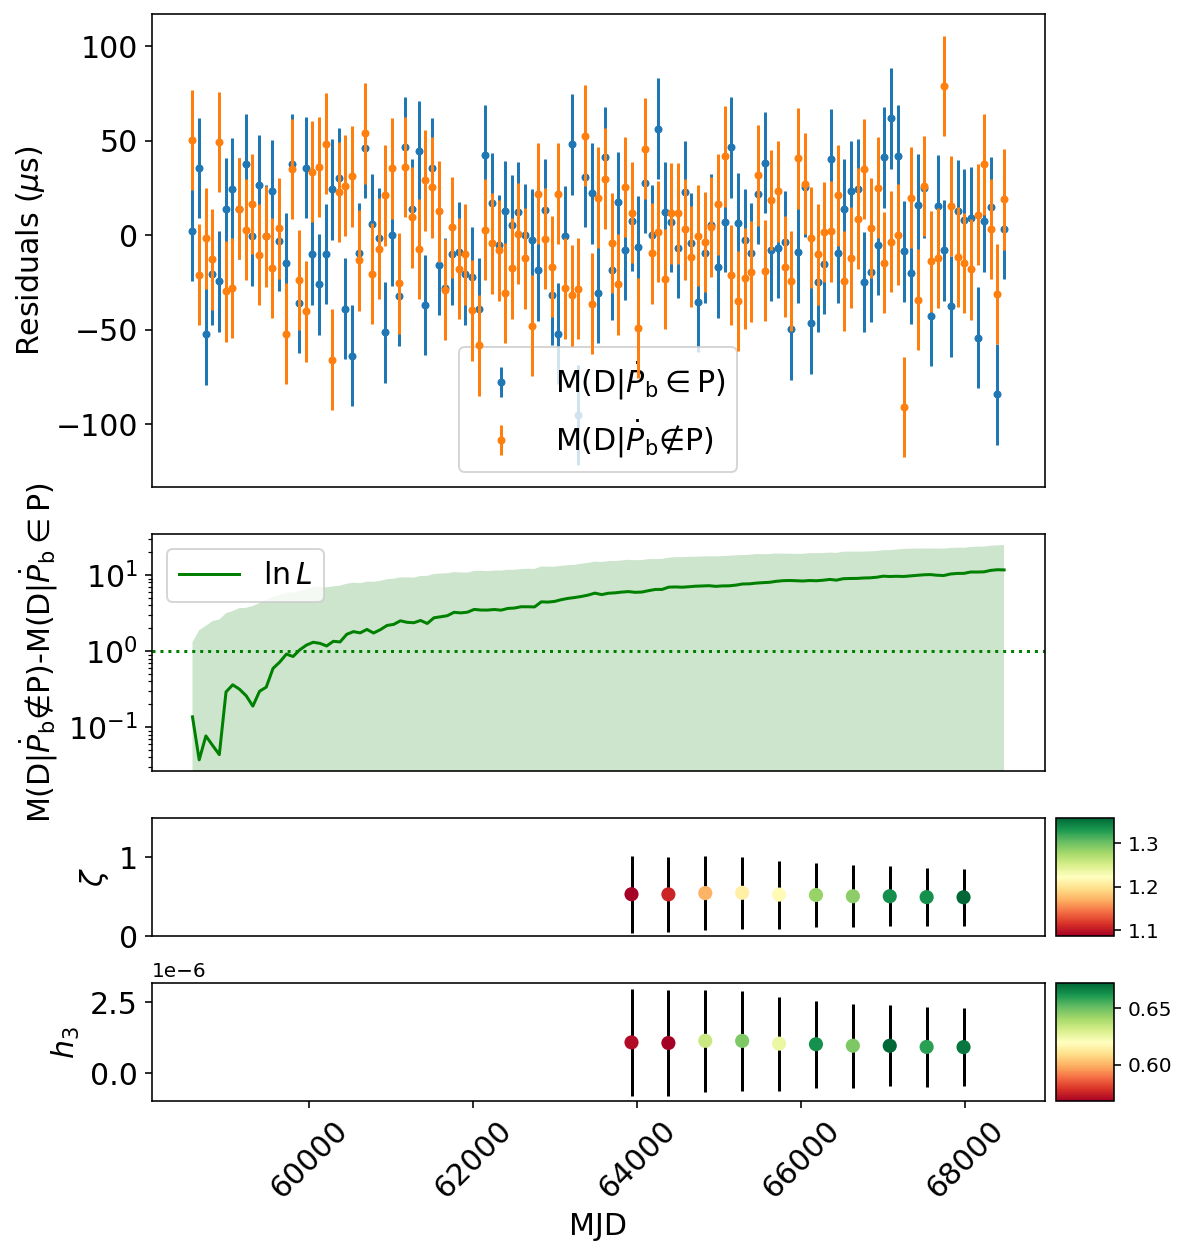

In [113]:
if Invest=='spr':
    f, (resid_fig, likeli_fig, meas_fig, meas_fig2) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [40, 20, 10,10]})

    resid_fig.figure.set_size_inches(16, 10)
    resid_fig.errorbar(mjd_range,perfect_res*1e+6,err_set,fmt='.',label=r'M(D|$\dot{P}_{\rm b}\in$P)')
    resid_fig.errorbar(mjd_range,weak_res*1e+6,err_set,fmt='.',label=r'M(D|$\dot{P}_{\rm b}\notin$P)',zorder=100)

    resid_fig.set_xticks([])
    resid_fig.set_ylabel('Residuals ($\mu$s)',fontsize=15, color='k')
    resid_fig.tick_params(axis='y',  labelsize=15)
    resid_fig.legend(fontsize=15)
    resid_fig.set_rasterized(True)


    likeli_fig.figure.set_size_inches(8, 10)
    likeli_fig.axhline(1,xmin=0,xmax=69000,linestyle=':',color='g')
    
    
    #sel_model=min(mjd_range_chisq[(lnL_mean/lnL_std)>sel])
#    likeli_fig.axhline(min(lnL_mean[mjd_range_chisq>sel_model]),xmin=0,xmax=69000,linestyle=':',color='r')
    likeli_fig.set_yscale('log')
    likeli_fig.fill_between(mjd_range_chisq, min_lnL_range, max_lnL_range,
                     facecolor="green", alpha=0.2)         
    likeli_fig.plot(mjd_range_chisq,lnL_mean,label=r'$\ln{L}$',color='green') 
 
    Z_mjd=mjd_range[1:][index_loc]
    mask= [np.around(i,3) in np.around(Z_mjd,3) for i in np.around(mjd_range[1:],3)]

    
    fitting_values=np.reshape(res_fit_val,[int(len(res_fit_val)/len(values)),len(values)])
    fitting_erorrs=np.reshape(res_fit_err,[int(len(res_fit_err)/len(errors)),len(errors)])    
    mass_measure=fitting_values[:,3].reshape(num_sim,len(index_loc)).mean(axis=0)
    mass_err=fitting_erorrs[:,3].reshape(num_sim,len(index_loc)).mean(axis=0)
    sini_measure=fitting_values[:,2].reshape(num_sim,len(index_loc)).mean(axis=0)
    sini_err=fitting_erorrs[:,2].reshape(num_sim,len(index_loc)).mean(axis=0)

        #pbd_measure_err=res_fit_val.reshape(num_sim,len(index_loc)).std(axis=0)
        #pbd_unc_err=res_fit_err.reshape(num_sim,len(index_loc)).std(axis=0)
    mask= [i in Z_mjd for i in mjd_range[1:]]
    lnL_mean_unc=lnL_mean[mask]
    min_lnL_cb=min_lnL_range[mask]
    max_lnL_cb=max_lnL_range[mask]
    min_lnL_cb=min_lnL_range[mask]
    max_lnL_cb=max_lnL_range[mask]
      


    Z = abs(sini_measure/sini_err)
        #normalize = colors.Normalize(vmin=Z.min(), vmax=Z.max())
        #Z_err=Z*np.sqrt((pbd_measure_err/pbd_measure)**2+(pbd_unc_err/pbd_unc)**2)


#    likeli_fig.axhline(min(lnL_mean_unc[Z>3]),xmin=0,xmax=69000,linestyle=':',color='r')
        #ax.axhline(min(Z[Z>3]),xmin=0,xmax=69000,linestyle=':',color='r')

    likeli_fig.set_ylabel(r'M(D|$\dot{P}_{\rm b}\notin$P)-M(D|$\dot{P}_{\rm b}\in$P)',fontsize=15, color='k')
    likeli_fig.legend(fontsize=15)
    likeli_fig.tick_params(axis='both', labelsize=15)
    likeli_fig.set_xticks([])


    color=meas_fig.scatter(Z_mjd,sini_measure,edgecolors='none',s=50,c=Z, cmap='RdYlGn',zorder=9999999)
    
    meas_fig.figure.set_size_inches(8, 10)
    meas_fig.errorbar(Z_mjd,sini_measure,sini_err,marker='.', linestyle='',color='k')
    meas_fig.set_ylabel(r'$\zeta$',fontsize=15, color='k')
    #meas_fig.set_xlabel('MJD',fontsize=15, color='k')
    meas_fig.set_xlim(min(mjd_range_chisq),max(mjd_range_chisq))
    meas_fig.set_ylim(0,1.5)
    meas_fig.tick_params(axis='both', labelsize=15)
    meas_fig.set_xticks([])   
    add_colorbar_outside(color,meas_fig)

    Z = abs(mass_measure/mass_err)
    color=meas_fig2.scatter(Z_mjd,mass_measure,edgecolors='none',s=50,c=Z, cmap='RdYlGn',zorder=9999999)
    meas_fig2.figure.set_size_inches(8, 10)
    meas_fig2.errorbar(Z_mjd,mass_measure,mass_err,marker='.', linestyle='',color='k')
    meas_fig2.set_ylabel(r'$h_{\rm 3}$',fontsize=15, color='k')
    meas_fig2.set_xlabel('MJD',fontsize=15, color='k')
    meas_fig2.set_xlim(min(mjd_range_chisq),max(mjd_range_chisq))
    #meas_fig2.set_ylim(,1.25+0.5)
    meas_fig2.tick_params(axis='both', labelsize=15)
    meas_fig2.tick_params(axis='x', labelsize=15,rotation=45)    
    add_colorbar_outside(color,meas_fig2)
    
    #plt.colorbar(color, format='%d', orientation='horizontal',shrink=0.6)
    plt.savefig('forecast_%s.pdf'%(incli), bbox_inches='tight', dpi=120)    
    plt.show()
    data=pd.DataFrame({'mjd':Z_mjd,'stig':sini_measure,'dstig':sini_err,'h3':mass_measure,'dh3':mass_err})
    data.to_csv('%s.csv'%incli)
else:
    f, (resid_fig, likeli_fig, meas_fig, meas_fig2) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [20, 20, 10,10]})

    resid_fig.figure.set_size_inches(16, 10)
    resid_fig.errorbar(mjd_range,perfect_res*1e+6,err_set,fmt='.',label=r'M(D|$\dot{P}_{\rm b}\in$P)')
    resid_fig.errorbar(mjd_range,weak_res*1e+6,err_set,fmt='.',label=r'M(D|$\dot{P}_{\rm b}\notin$P)',zorder=100)

    resid_fig.set_xticks([])
    resid_fig.set_ylabel('Residuals ($\mu$s)',fontsize=15, color='k')
    resid_fig.tick_params(axis='y',  labelsize=15)
    resid_fig.legend(fontsize=15)
    resid_fig.set_rasterized(True)


    likeli_fig.figure.set_size_inches(8, 10)
    likeli_fig.axhline(1,xmin=0,xmax=69000,linestyle=':',color='g')
    
    
    sel_model=min(mjd_range_chisq[(lnL_mean/lnL_std)>sel])
    likeli_fig.axhline(min(lnL_mean[mjd_range_chisq>sel_model]),xmin=0,xmax=69000,linestyle=':',color='r')
    likeli_fig.set_yscale('log')
    likeli_fig.fill_between(mjd_range_chisq, min_lnL_range, max_lnL_range,
                     facecolor="green", alpha=0.2)         
    likeli_fig.plot(mjd_range_chisq,lnL_mean,label=r'$\ln{L}$',color='green') 
 
    Z_mjd=mjd_range[1:][index_loc]
    mask= [np.around(i,3) in np.around(Z_mjd,3) for i in np.around(mjd_range[1:],3)]


    pbd_measure=res_fit_val.reshape(num_sim,len(index_loc)).mean(axis=0)
    pbd_unc=res_fit_err.reshape(num_sim,len(index_loc)).mean(axis=0)
    mask= [i in Z_mjd for i in mjd_range[1:]]
    lnL_mean_unc=lnL_mean[mask]
    min_lnL_cb=min_lnL_range[mask]
    max_lnL_cb=max_lnL_range[mask]
    min_lnL_cb=min_lnL_range[mask]
    max_lnL_cb=max_lnL_range[mask]

    
    Z = abs(pbd_measure/pbd_unc)

    color=likeli_fig.scatter(Z_mjd,lnL_mean_unc,edgecolors='none',s=50,c=Z, cmap='RdYlGn')

    likeli_fig.axhline(min(lnL_mean_unc[Z>3]),xmin=0,xmax=69000,linestyle=':',color='r')
    likeli_fig.set_ylabel(r'M(D|$\dot{P}_{\rm b}\notin$P)-M(D|$\dot{P}_{\rm b}\in$P)',fontsize=15, color='k')
    likeli_fig.legend(fontsize=15)
    likeli_fig.tick_params(axis='both', labelsize=15)
    likeli_fig.set_xticks([])

    add_colorbar_outside(color,likeli_fig)

    meas_fig.figure.set_size_inches(8, 10)
    meas_fig.errorbar(Z_mjd,pbd_measure,pbd_unc,marker='.', linestyle='',color='k')
    meas_fig.axhline(1.7417306822136477e-15,linestyle=':',color='b')
    meas_fig.axhline(1.1530558681173629e-14,linestyle=':',color='b')
    meas_fig.set_ylabel(r'$\dot{P}_{\rm b}$',fontsize=15, color='k')
    meas_fig.set_xlabel('MJD',fontsize=15, color='k')
    meas_fig.set_xlim(min(mjd_range_chisq),max(mjd_range_chisq))
    meas_fig.set_ylim(-5e-14,6e-14)
    meas_fig.tick_params(axis='both', labelsize=15)
    meas_fig.tick_params(axis='x', labelsize=15,rotation=45)    



    #plt.colorbar(color, format='%d', orientation='horizontal',shrink=0.6)
    plt.savefig('forecast.pdf', bbox_inches='tight', dpi=120)    
    plt.show()